### Import libraries

In [1]:
import sys
import random

from pathlib import Path

import numpy as np
import pandas as pd

import networkx as nx

import torch
from torch.nn import Linear
import torch.nn.functional as F


import matplotlib.pyplot as plt
%matplotlib inline 

DIR_PATH = Path.cwd().parent
sys.path.append(str(DIR_PATH))

from src.dataset.loader import load_data

# reload modules
%load_ext autoreload
%autoreload 2

c:\Users\useva\.conda\envs\gnn_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Fix seed

In [2]:
seed = 42
random.seed(seed)   
np.random.seed(seed)

torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

### Useful variables

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')  

DATA_BASE = DIR_PATH / 'data/preprocessed/'
BALANCED_PATH = DATA_BASE / 'balanced'
UNBALANCED_PATH = DATA_BASE / 'unbalanced'

Device: cuda


### Balanced Dataset

In [4]:
A, features = load_data(BALANCED_PATH)  

# Print information about the dataset
print(f'Number of graphs: {len(A)}')
print(f'Number of nodes: {A[0].shape[0]}')
print(f'Number of features (per node): {len(features.iloc[0]["Prot1"].tolist()) if isinstance(features.iloc[0]["Prot1"].tolist(), list) else 1 }') 
print(f'Classes distribution:\n {features["class"].value_counts()}')

Number of graphs: 500
Number of nodes: 20
Number of features (per node): 1
Classes distribution:
 0    269
1    231
Name: class, dtype: int64


In [5]:
"""
print(f"deg(A) = {G.degree['A']}")
print(f"deg^-(A) = {DG.in_degree['A']}")
print(f"deg^+(A) = {DG.out_degree['A']}")


print(f"Degree centrality      = {nx.degree_centrality(G)}ф")
print(f"Closeness centrality   = {nx.closeness_centrality(G)}")
print(f"Betweenness centrality = {nx.betweenness_centrality(G)}")
"""

'\nprint(f"deg(A) = {G.degree[\'A\']}")\nprint(f"deg^-(A) = {DG.in_degree[\'A\']}")\nprint(f"deg^+(A) = {DG.out_degree[\'A\']}")\n\n\nprint(f"Degree centrality      = {nx.degree_centrality(G)}ф")\nprint(f"Closeness centrality   = {nx.closeness_centrality(G)}")\nprint(f"Betweenness centrality = {nx.betweenness_centrality(G)}")\n'

c:\Users\useva\.conda\envs\gnn_env\lib\site-packages\networkx\drawing\nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


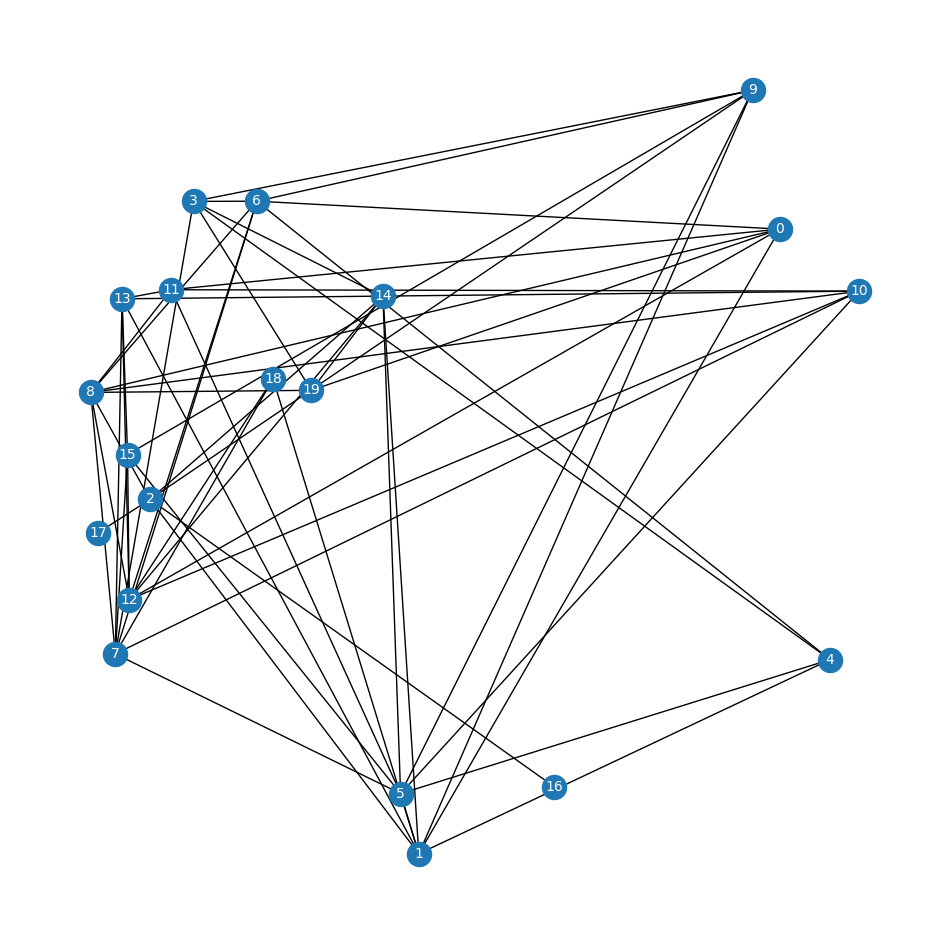

In [6]:
G=nx.from_numpy_array(A[0])

plt.figure(figsize=(12,12))
plt.axis('off')
nx.draw_networkx(G,
                 pos=nx.spring_layout(G, seed=0),
                 node_size=300,
                 cmap='coolwarm',
                 font_size=10,
                 font_color='white'
                 )

#nx.is_connected(G) # Is a graph connected (path to any node from any node)
#labels = {k: round(v, 3) for k, v in nx.get_edge_attributes(G, "weight").items()} # round to 3 digits
#nx.draw_networkx_edge_labels(G, pos=nx.spring_layout(G, seed=0), edge_labels=labels, )

### Apply simple MLP, ignore the topology

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

class Data(torch.utils.data.Dataset):
    def __init__(self, x, y, A=None, device=None):
        id_train_, id_val = train_test_split(np.arange(len(x)), test_size=0.2, stratify=y, random_state=42)
        id_train, id_test = train_test_split(np.arange(len(id_train_)), test_size=0.2, stratify=y[id_train_], random_state=42)
        
        self.x_train, self.y_train = torch.tensor(x[id_train], dtype=torch.float32).to(device), torch.tensor(y[id_train], dtype=torch.float32).to(device)
        self.x_val, self.y_val = torch.tensor(x[id_val], dtype=torch.float32).to(device), torch.tensor(y[id_val], dtype=torch.float32).to(device)
        self.x_test, self.y_test = torch.tensor(x[id_test], dtype=torch.float32).to(device), torch.tensor(y[id_test], dtype=torch.float32).to(device)
        
        # store the topology if provided
        if A is not None:
            
            # A_hat = A + I
            A_tensor = torch.tensor(A, dtype=torch.float32).to(device)
            identity =  torch.eye(A_tensor.size(1), device=device).expand(A_tensor.size(0), -1, -1) # (samples, num_nodes, num_nodes)

            A_hat = A_tensor + identity
            
            self.A_train = torch.tensor(A_hat[id_train], dtype=torch.float32).to(device)
            self.A_val = torch.tensor(A_hat[id_val], dtype=torch.float32).to(device)
            self.A_test = torch.tensor(A_hat[id_test], dtype=torch.float32).to(device)  

            # D_hat_inv_sqrt = DD_hat_inv_sqrt + I
            D_tensor = torch.zeros_like(A_tensor)
            for i in range(D_tensor.size(0)):
                for n in range(D_tensor.shape[1]):
                    D_tensor[i, n, n] = A_tensor[i, n, :].sum(dim=0)
            
            D_hat = D_tensor + identity
            D_hat_inv_sqrt = torch.pow(D_hat, -0.5)
   
            self.D_hat_inv_sqrt_train = torch.tensor(D_hat_inv_sqrt[id_train], dtype=torch.float32).to(device)
            self.D_hat_inv_sqrt_val = torch.tensor(D_hat_inv_sqrt[id_val], dtype=torch.float32).to(device)
            self.D_hat_inv_sqrt_test = torch.tensor(D_hat_inv_sqrt[id_test], dtype=torch.float32).to(device)  

            
    def shuffle(self):
        # shuffle the topology if available
        if hasattr(self, 'A_train'): 
            self.x_train, self.y_train, self.A_train = shuffle(self.x_train, self.y_train, self.A_train)
            self.x_val, self.y_val, self.A_val = shuffle(self.x_val, self.y_val, self.A_val)
            self.x_test, self.y_test, self.A_test = shuffle(self.x_test, self.y_test, self.A_test)
        else:
            self.x_train, self.y_train = shuffle(self.x_train, self.y_train)
            self.x_val, self.y_val = shuffle(self.x_val, self.y_val)
            self.x_test, self.y_test = shuffle(self.x_test, self.y_test)
        
    def print_info(self):
        """Print dataset info."""
        print(f'Number of training samples: {len(self.x_train)}')
        print(f'Number of validation samples: {len(self.x_val)}')
        print(f'Number of test samples: {len(self.x_test)}')
        if hasattr(self, 'A_train'):
            print(f'Topology is stored.')
        else:
            print(f'Topology is not stored.')
        
    

In [8]:
X, y = features[[f'Prot{i+1}' for i in range(20)]].values, np.expand_dims(features['class'].values, axis=-1)
#X, y = np.expand_dims(features[[f'Prot{i+1}' for i in range(20)]].values, axis=-1), np.expand_dims(features['class'].values, axis=1)
print(X.shape, y.shape)

data = Data(X, y, device=device)   
data.print_info()

(500, 20) (500, 1)
Number of training samples: 320
Number of validation samples: 100
Number of test samples: 80
Topology is not stored.


In [9]:
def accuracy(y_pred, y_true):
    """Calculate accuracy."""
    return torch.sum(y_pred == y_true) / len(y_true)

In [10]:
class MLP(torch.nn.Module):
    """Multilayer Perceptron"""
    def __init__(self, dim_in, dim_h):
        super().__init__()
        self.linear1 = Linear(dim_in, dim_h)
        self.linear2 = Linear(dim_h, 1)

    def forward(self, x):
        x = self.linear1(x)
        x = torch.relu(x)
        x = self.linear2(x)
        return torch.sigmoid(x)

    def fit(self, data, epochs):
        criterion = torch.nn.BCELoss()
        optimizer = torch.optim.Adam(self.parameters(),
                                          lr=0.01,
                                          weight_decay=5e-4)

        self.train()
        for epoch in range(epochs+1): 
            data.shuffle() # shuffle data 
            
            optimizer.zero_grad()
            out_train = self(data.x_train)
            
            loss = criterion(out_train, data.y_train)
            acc = accuracy(out_train>=0.5, data.y_train)
            loss.backward()
            optimizer.step()

            if(epoch % 20 == 0):
                with torch.no_grad():
                    out_val = self(data.x_val)
                    val_loss = criterion(out_val, data.y_val)
                    val_acc = accuracy(out_val>=0.5, data.y_val)
                    print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc:'
                        f' {acc*100:>5.2f}% | Val Loss: {val_loss:.2f} | '
                        f'Val Acc: {val_acc*100:.2f}%')

    @torch.no_grad()      
    def test(self, data):
        self.eval()
        out = self(data.x_test)
        acc = accuracy(out>=0.5, data.y_test)
        return acc

In [11]:
# Create MLP model
mlp = MLP(dim_in=20, dim_h=16).to(device)
print(mlp)

# Train
mlp.fit(data, epochs=100)

# Test
acc = mlp.test(data)
print(f'\nMLP test accuracy: {acc*100:.2f}%')


MLP(
  (linear1): Linear(in_features=20, out_features=16, bias=True)
  (linear2): Linear(in_features=16, out_features=1, bias=True)
)
Epoch   0 | Train Loss: 0.666 | Train Acc: 58.75% | Val Loss: 0.66 | Val Acc: 63.00%
Epoch  20 | Train Loss: 0.334 | Train Acc: 85.62% | Val Loss: 0.37 | Val Acc: 85.00%
Epoch  40 | Train Loss: 0.220 | Train Acc: 90.94% | Val Loss: 0.30 | Val Acc: 88.00%
Epoch  60 | Train Loss: 0.148 | Train Acc: 95.94% | Val Loss: 0.26 | Val Acc: 90.00%
Epoch  80 | Train Loss: 0.091 | Train Acc: 98.12% | Val Loss: 0.26 | Val Acc: 93.00%
Epoch 100 | Train Loss: 0.058 | Train Acc: 99.38% | Val Loss: 0.28 | Val Acc: 92.00%

MLP test accuracy: 83.75%


### GNN (Vanilla) from scratch

In [12]:
X, y = np.expand_dims(features[[f'Prot{i+1}' for i in range(20)]].values, axis=-1) , np.expand_dims(features['class'].values, axis=-1)
print(X.shape, y.shape)

data = Data(X, y, A, device=device)   
data.print_info()

(500, 20, 1) (500, 1)


C:\Users\useva\AppData\Local\Temp\ipykernel_13100\2974270894.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.A_train = torch.tensor(A_hat[id_train], dtype=torch.float32).to(device)
C:\Users\useva\AppData\Local\Temp\ipykernel_13100\2974270894.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.A_val = torch.tensor(A_hat[id_val], dtype=torch.float32).to(device)
C:\Users\useva\AppData\Local\Temp\ipykernel_13100\2974270894.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.A_test = torch.tensor(A_hat[id_test], dtype=tor

Number of training samples: 320
Number of validation samples: 100
Number of test samples: 80
Topology is stored.


C:\Users\useva\AppData\Local\Temp\ipykernel_13100\2974270894.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.D_hat_inv_sqrt_train = torch.tensor(D_hat_inv_sqrt[id_train], dtype=torch.float32).to(device)
C:\Users\useva\AppData\Local\Temp\ipykernel_13100\2974270894.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.D_hat_inv_sqrt_val = torch.tensor(D_hat_inv_sqrt[id_val], dtype=torch.float32).to(device)
C:\Users\useva\AppData\Local\Temp\ipykernel_13100\2974270894.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.D_h

In [13]:
class VanillaGNNLayer(torch.nn.Module):
    def __init__(self, dim_in, dim_out):
        super().__init__()
        self.linear = Linear(dim_in, dim_out, bias=False)

    def forward(self, x, adjacency):
        x = torch.bmm(adjacency, x)
        x = self.linear(x)
        return x

In [14]:
class VanillaGNNLayer(torch.nn.Module):
    def __init__(self, dim_in, dim_out):
        super().__init__()
        self.linear = Linear(dim_in, dim_out, bias=False)

    def forward(self, x, adjacency):
        x = torch.bmm(adjacency, x)
        x = self.linear(x)
        return x
    
class VanillaGNN(torch.nn.Module):
    """Vanilla Graph Neural Network"""
    def __init__(self, dim_in, dim_h, nodes):
        super().__init__()
        self.gnn = VanillaGNNLayer(dim_in, 1) # Note: Instead of 1, use dim_h and readout
        #self.gnn1 = VanillaGNNLayer(dim_in, dim_h)
        #self.gnn2 = VanillaGNNLayer(dim_h, 1)
        self.out = Linear(nodes, 1)

    def forward(self, x, adjacency):
        # Overfits
        #h = self.gnn1(x, adjacency)
        #h = torch.relu(h)
        #h = self.gnn2(h, adjacency)
        
        h = torch.relu(self.gnn(x, adjacency))
        h = h.squeeze(-1) # (samples, nodes, 1) -> (samples, nodes)
        out = self.out(h)    
        return torch.sigmoid(out)

    def fit(self, data, epochs):
        criterion = torch.nn.BCELoss()
        optimizer = torch.optim.Adam(self.parameters(),
                                          lr=0.01,
                                          weight_decay=5e-4)

        self.train()
        for epoch in range(epochs+1): 
            data.shuffle() # shuffle data 
            
            optimizer.zero_grad()
            out_train = self(data.x_train, data.A_train)
            loss = criterion(out_train, data.y_train)
            acc = accuracy(out_train>=0.5, data.y_train)
            loss.backward()
            optimizer.step()

            if(epoch % 20 == 0):
                with torch.no_grad():
                    out_val = self(data.x_val, data.A_val)
                    val_loss = criterion(out_val, data.y_val)
                    val_acc = accuracy(out_val>=0.5, data.y_val)
                    print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc:'
                        f' {acc*100:>5.2f}% | Val Loss: {val_loss:.2f} | '
                        f'Val Acc: {val_acc*100:.2f}%')

    @torch.no_grad()      
    def test(self, data):
        self.eval()
        out = self(data.x_test, data.A_test)
        acc = accuracy(out>=0.5, data.y_test)
        return acc

In [15]:
# Create the Vanilla GNN model
gnn = VanillaGNN(dim_in=1, dim_h=16, nodes=20).to(device)
print(gnn)

# Train
gnn.fit(data, epochs=100)

# Test
acc = gnn.test(data)
print(f'\nGNN test accuracy: {acc*100:.2f}%')

VanillaGNN(
  (gnn): VanillaGNNLayer(
    (linear): Linear(in_features=1, out_features=1, bias=False)
  )
  (out): Linear(in_features=20, out_features=1, bias=True)
)
Epoch   0 | Train Loss: 0.701 | Train Acc: 52.81% | Val Loss: 0.70 | Val Acc: 54.00%
Epoch  20 | Train Loss: 0.612 | Train Acc: 74.69% | Val Loss: 0.63 | Val Acc: 69.00%
Epoch  40 | Train Loss: 0.493 | Train Acc: 79.06% | Val Loss: 0.54 | Val Acc: 71.00%
Epoch  60 | Train Loss: 0.411 | Train Acc: 81.56% | Val Loss: 0.49 | Val Acc: 77.00%
Epoch  80 | Train Loss: 0.364 | Train Acc: 85.31% | Val Loss: 0.47 | Val Acc: 78.00%
Epoch 100 | Train Loss: 0.334 | Train Acc: 86.25% | Val Loss: 0.46 | Val Acc: 78.00%

GNN test accuracy: 82.50%


### Graph Convolutional Network (GCN)

In [16]:
class VanillaGCNLayer(torch.nn.Module):
    def __init__(self, dim_in, dim_out):
        super().__init__()
        self.linear = Linear(dim_in, dim_out, bias=False)
        

    def forward(self, x, adjacency, degree_inv_sqrt):
        
        x =torch.bmm(degree_inv_sqrt, x)
        print('1', x.shape)
        x = torch.bmm(adjacency, x)
        print('2', x.shape)
        x =torch.bmm(degree_inv_sqrt, x)
        print('3', x.shape)
        x = self.linear(x)
        print('4', x.shape)
        return x
   
    
class VanillaGCN(torch.nn.Module):
    """Vanilla Graph Neural Network"""
    def __init__(self, dim_in, dim_h, nodes):
        super().__init__()
        self.gnn = VanillaGCNLayer(dim_in, 1) # Note: Instead of 1, use dim_h and readout
        self.out = Linear(nodes, 1)

    def forward(self, x, adjacency, degree):
        h = torch.relu(self.gnn(x, adjacency, degree))
        h = h.squeeze(-1) # (samples, nodes, 1) -> (samples, nodes)
        out = self.out(h)    
        return torch.sigmoid(out)

    def fit(self, data, epochs):
        criterion = torch.nn.BCELoss()
        optimizer = torch.optim.Adam(self.parameters(),
                                          lr=0.01,
                                          weight_decay=5e-4)

        self.train()
        for epoch in range(epochs+1): 
            data.shuffle() # shuffle data 
            
            #degree_inv_sqrt = self._get_degree_inv_sqrt(data.A
            optimizer.zero_grad()
            out_train = self(data.x_train, data.A_train, data.D_hat_inv_sqrt_train)
            loss = criterion(out_train, data.y_train)
            acc = accuracy(out_train>=0.5, data.y_train)
            loss.backward()
            optimizer.step()

            if(epoch % 20 == 0):
                with torch.no_grad():
                    out_val = self(data.x_val, data.A_val, data.D_hat_inv_sqrt_val)
                    val_loss = criterion(out_val, data.y_val)
                    val_acc = accuracy(out_val>=0.5, data.y_val)
                    print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc:'
                        f' {acc*100:>5.2f}% | Val Loss: {val_loss:.2f} | '
                        f'Val Acc: {val_acc*100:.2f}%')

    @torch.no_grad()      
    def test(self, data):
        self.eval()
        out = self(data.x_test, data.A_test, data.D_hat_inv_sqrt_test)
        acc = accuracy(out>=0.5, data.y_test)
        return acc

In [17]:
"""
# Create the Vanilla GNN model
gnn = VanillaGCN(dim_in=1, dim_h=16, nodes=20).to(device)
print(gnn)

# Train
gnn.fit(data, epochs=100)

# Test
acc = gnn.test(data)
print(f'\nGCN test accuracy: {acc*100:.2f}%')

"""

VanillaGCN(
  (gnn): VanillaGCNLayer(
    (linear): Linear(in_features=1, out_features=1, bias=False)
  )
  (out): Linear(in_features=20, out_features=1, bias=True)
)
1 torch.Size([320, 20, 1])
2 torch.Size([320, 20, 1])
3 torch.Size([320, 20, 1])
4 torch.Size([320, 20, 1])


RuntimeError: CUDA error: CUBLAS_STATUS_EXECUTION_FAILED when calling `cublasSgemm( handle, opa, opb, m, n, k, &alpha, a, lda, b, ldb, &beta, c, ldc)`